<a href="https://colab.research.google.com/github/paysis/advertising-linear-regression/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV dosyasını kolaylık açısından kendi github repo'mda sakladım. Böylece her çalıştırmada otomatik csv dosyasını tekrar notebook ortamına indirebiliyorum.

In [1]:
!wget https://raw.githubusercontent.com/paysis/advertising-linear-regression/refs/heads/main/Advertising.csv

--2024-12-01 22:15:43--  https://raw.githubusercontent.com/paysis/advertising-linear-regression/refs/heads/main/Advertising.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4756 (4.6K) [text/plain]
Saving to: ‘Advertising.csv’

Advertising.csv     100%[===================>]   4.64K  --.-KB/s    in 0s      

2024-12-01 22:15:43 (43.8 MB/s) - ‘Advertising.csv’ saved [4756/4756]



# Import

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Veri Analizi

Öncelikle elimizdeki veriyi analiz edip daha iyi anlamaya çalışacağım ve böylece alınabilecek aksiyonları belirleyeceğim. Veriyi preprocessing işleminden geçirip sonraki başlık altında lineer regresyon yapacağım.

In [3]:
df = pd.read_csv("Advertising.csv")

In [4]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


İlk sütun CSV içerisindeki ID değerlerini içeriyor. Bizim çözümümüzde ID değerleriyle bir işimiz yok, bu yüzden bunları data frame içerisinden kaldırıyorum.

In [6]:
df = df[df.columns[1:]]
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Sütunlar içerisinde NA değerler var mı diye kontrol ediyorum. Eğer varsa bu NA değerlerini doldurmamız gerekecek.

In [8]:
df.isna().sum()

,0
TV,0
radio,0
newspaper,0
sales,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


Tüm sütunlar dolu ve sayısal tipte. Bu durumda bir problemimiz yok, analize devam edebiliriz. Şimdi data frame'in istatistiklerine bakalım.

In [10]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Buradan tüm sütunların pozitif ondalıklı sayı (float64) değerlerine sahip olduklarını görüyoruz. Sütunların standart sapmalarını ve ortalamalarını da çıktıda (mean ve std) gözlemleyebiliyoruz.

IQR yöntemi kullanarak aykırı değerleri görmek istiyorum. Bunun sonucunda bulduğumuz aykırıları temizleyip veriyi iyileştirebileceğimizi düşünüyorum.

Hemen aşağıda IQR ile aykırı verileri temizlemeden önce kutu grafiğimizle aykırı verileri görebiliyoruz. Buna göre sadece newspaper sütununda aykırı veriler görünüyor. Veri setimizde toplam 200 adet veri olduğu için bu verileri silmek yerine IQR yöntemi kullanıp doğru veri aralığına getireceğim. Böylece 200 adet verimiz olmaya devam edecek ve aynı zamanda aykırılardan kurtulmuş olacağız. Veri setimiz küçük olduğu için en mantıklı yöntemin bu olduğunu düşünüyorum.

<Axes: >

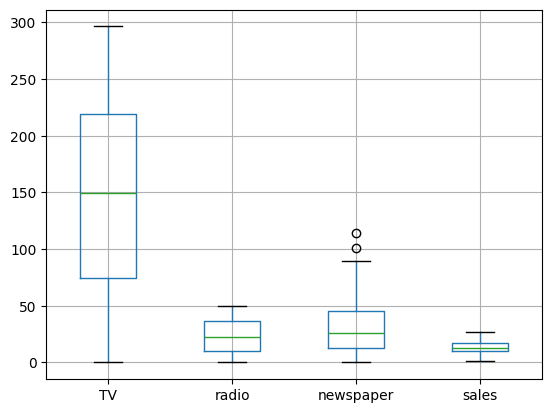

In [16]:
df.boxplot()

Burada IQR yöntemi kullanarak aykırıları istediğimiz aralığa sokuyoruz.

In [14]:
iqr_df = df.copy()

for col in df.columns:
  col_q1 = df[col].quantile(0.25)
  col_q3 = df[col].quantile(0.75)
  col_iqr = col_q3 - col_q1
  col_lower_limit = col_q1 - 1.5 * col_iqr
  col_upper_limit = col_q3 + 1.5 * col_iqr

  iqr_df[col] = iqr_df[col].clip(col_lower_limit, col_upper_limit)

iqr_df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.415750,14.022500
std,85.854236,14.846809,21.316901,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,93.625000,27.000000


IQR yöntemi ile temizlenmiş veri kümemizde artık aykırı veri olmadığını görüyoruz.

<Axes: >

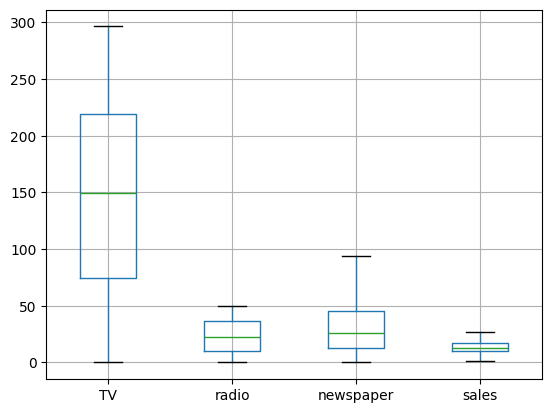

In [15]:
iqr_df.boxplot()

In [17]:
df = iqr_df

Şimdi ise korelasyon matrisimizi çizdirip sütunlar arasındaki ilişkiyi gözlemleyeceğim.

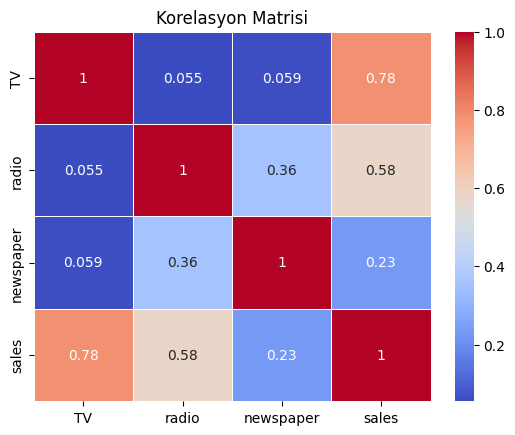

In [18]:
corr_mx = df.corr() # tüm sütunlar sayısal tipte olduğu için direkt df üzerinde corr çağırıyorum.

sns.heatmap(corr_mx, annot=True, cmap="coolwarm", linewidths=0.4)
plt.title("Korelasyon Matrisi")
plt.show()

Bu korelasyon matrisinden elde ettiğim sonuçları şöyle özetleyebilirim:

- TV ile radio arasında ihmal edilebilir bir ilişki bulunuyor.
- TV ile newspaper arasında ihmal edilebilir bir ilişki bulunuyor.
- TV ile sales arasında pozitif güçlü bir ilişki bulunuyor.
- radio ile newspaper arasında pozitif zayıf-orta bir ilişki bulunuyor.
- radio ile sales arasında pozitif orta bir ilişki bulunuyor.
- newspaper ile sales arasında pozitif zayıf bir ilişki bulunuyor.

Şimdi ise verileri normalize etmek amacıyla Min-Max ölçeklendirme işlemi yapacağım.

In [19]:
def mix_max_scale(df):
  return (df - df.min()) / (df.max() - df.min())

df = mix_max_scale(df)

In [20]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,0.494902,0.469032,0.322698,0.489075
std,0.290342,0.299331,0.228416,0.205412
min,0.000000,0.000000,0.000000,0.000000
25%,0.249155,0.201109,0.133405,0.345472
50%,0.504058,0.461694,0.272703,0.444882
75%,0.737656,0.736391,0.480043,0.622047
max,1.000000,1.000000,1.000000,1.000000


Görülebileceği üzere min ve max değerleri [0-1] aralığına çekildi. Böylece bir sütunun, diğer sütunlara göre model üzerinde baskın etki oluşturmasını önlemiş olacağız.

# Lineer Regresyon

Şimdi ise lineer regresyon modelimi oluşturup modeli elimdeki verilerle eğiteceğim. Bunun için train ve test kümeleri oluşturmam gerekiyor.

Train: 150 adet

Test: 50 adet

In [24]:
train_df, test_df = train_test_split(df, train_size=150)

train_df.count(), test_df.count()

(TV           150
 radio        150
 newspaper    150
 sales        150
 dtype: int64,
 TV           50
 radio        50
 newspaper    50
 sales        50
 dtype: int64)

In [25]:
train_X = train_df.drop("sales", axis=1)
train_y = train_df["sales"]

test_X = test_df.drop("sales", axis=1)
test_y = test_df["sales"]

Şimdi modeli oluşturabilirim.

In [29]:
model = LinearRegression()

Modeli train kümesiyle eğitiyorum.

In [30]:
_ = model.fit(train_X, train_y)

Test kümesini alıp tahminlerde bulunacağım. Bu tahminleri ve gerçek değerlerimizi bir grafikte karşılaştıracağım

In [32]:
y_pred = model.predict(test_X)

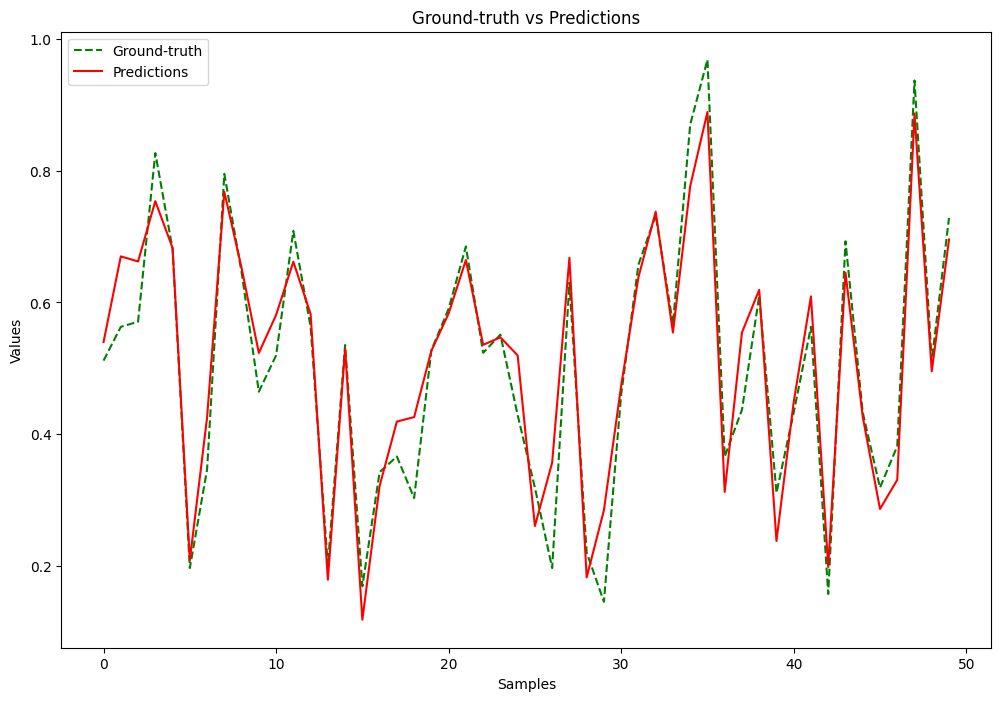

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(test_y.values, label='Ground-truth', color='g', linestyle='--')
plt.plot(y_pred, label='Predictions', color='r', linestyle='-')
plt.title("Ground-truth vs Predictions")
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

Şimdi hata hesabı yapacağım.

In [36]:
L1_norm = mean_absolute_error(test_y, y_pred)
L2_norm = mean_squared_error(test_y, y_pred)

In [38]:
print(f"L1 Norm (MAE): {L1_norm}")
print(f"L2 Norm (MSE): {L2_norm}")

L1 Norm (MAE): 0.045453472391563235
L2 Norm (MSE): 0.0035235917139726436


# Sonuç

Oluşturduğum modelin gerçek değerlere çok yakın değerler tahmin edebildiğini gözlemledim. L1 ve L2 hata hesaplamalarında ise L1 hatasının daha yüksek değere sahip olduğunu gördüm.